# Import required libraries

In [ ]:
import glob
import pandas as pd
#pandas
import numpy as np
#numpy
import matplotlib.pyplot as plt
#matplotlib
import seaborn as sns
#seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#sklearn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
# from keras.optimizers import Adam
#keras
import tensorflow as tf
#tensorflow
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#nltk
import re
import os
#other useful stuff
from wordcloud import WordCloud, STOPWORDS
#wordclouds and cloud stopwords
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/BIA-667/tweets_with_labels.csv")
# data = pd.read_csv("/content/drive/MyDrive/datasets/tweets_with_labels.csv")
data["text"] = data[" text"]
data = data.drop(["tweet_id", "user_id", "tweet_timestamp", " text"], axis=1) # drop the columns that we do not care about
print(f"Total tweets captured from twitter API: {len(data)}")

# Tweet lenghts that <3 and >230 chars might be a result of error in tweet collection and preprocessing
cnt = 0
short_ids = []
long_ids = []
for idx, tweet in enumerate(data["text"]):
  if len(tweet) < 4:
    short_ids.append(idx)
    cnt += 1
  elif len(tweet) > 280:
    long_ids.append(idx)
    cnt += 1

ids_to_drop = short_ids + long_ids

print(f"Dropping {len(short_ids)} less than 4 chars, and {len(long_ids)} as they are over 280 chars, total of {len(ids_to_drop)}")
data = data.drop(index=ids_to_drop)
print(f"Tweets available {len(data)}")

Total tweets captured from twitter API: 928881
Dropping 411 less than 4 chars, and 28327 as they are over 280 chars, total of 28738
Tweets available 900143


In [ ]:
# Reduce the datasize to 500,000 to experiment
data = data[:500000]

In [ ]:
data.head()

,keyword,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,text
0,wuhan,0.384,0.572,0.358,0.195,0.453,negative,fear,The Wuhan Virus: How to Stay Safe
1,wuhan,0.460,0.359,0.435,0.276,0.406,negative,anger,@Jimmyjude13 Well I mean...
2,wuhan,0.443,0.459,0.410,0.278,0.369,negative,fear,US to expand virus screening at 20 airports fo...
3,wuhan,0.403,0.520,0.448,0.224,0.449,negative,fear,@DrOz: Reports surrounding coronavirus have be...
4,wuhan,0.503,0.465,0.378,0.338,0.409,neutral or mixed,no specific emotion,Wuhan in lock down: I speak with Wayne Dupleis...


# Visualise data

In [ ]:
counts = {}
lenghts = []
for tw in data["text"]:
  lens = len(tw)
  lenghts.append(lens)
  if lens in counts:
    counts[lens] = counts[lens] + 1
  else:
    counts[lens] = 1

In [ ]:
pdc = pd.DataFrame(lenghts)

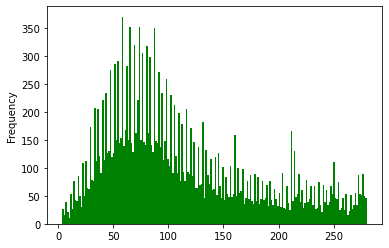

In [ ]:
pdc[0].plot.hist(bins=200, color='g')

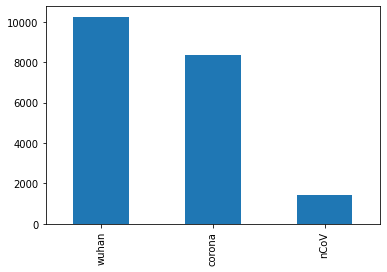

In [ ]:
data["keyword"].value_counts().plot(kind="bar")

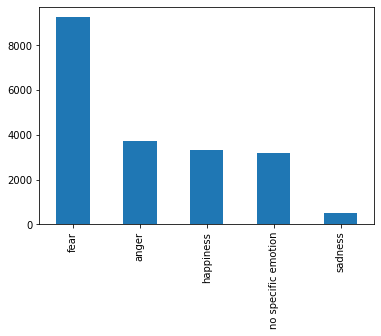

In [ ]:
data["emotion"].value_counts().plot(kind="bar")

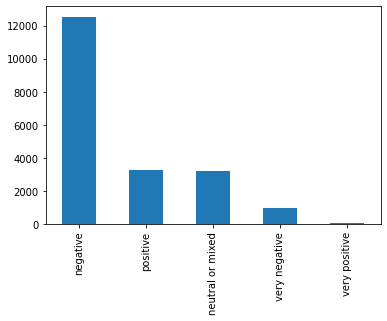

In [ ]:
data["sentiment"].value_counts().plot(kind="bar")

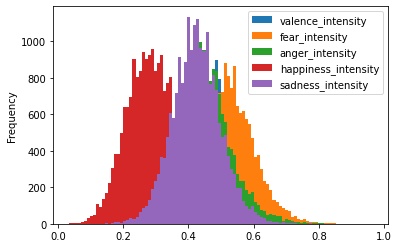

In [ ]:
data.plot.hist(bins=100)

In [ ]:
# tweet_text = data.text
# # only consider the top max_features 10000 ordered by term frequency across the corpus.
# # min_df - try this to improve efficieny
# vectorizer = TfidfVectorizer(stop_words="english", lowercase=True, analyzer = 'word', max_features=10000)
# X = vectorizer.fit_transform(tweet_text)

In [ ]:
data.drop(['keyword','valence_intensity','fear_intensity','anger_intensity','happiness_intensity', 'sadness_intensity', 'sentiment'], axis=1, inplace=True)

In [ ]:
data.emotion = data.emotion.replace({'fear': 0, 'anger': 1, 'no specific emotion': 2, 'happiness': 3,'sadness': 4 })
data.emotion.unique()

array([0, 1, 2, 3, 4])

In [ ]:
english_stopwords = stopwords.words('english')
#base of english stopwords
stemmer = SnowballStemmer('english')
#stemming algorithm
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
#regex for mentions and links in tweets

In [ ]:
def preprocess(content, stem=False):
  english_stopwords = stopwords.words('english')
  #base of english stopwords
  stemmer = SnowballStemmer('english')
  #stemming algorithm
  regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
  #regex for mentions and links in tweets
  content = re.sub(regex, ' ', str(content).lower()).strip()
  tokens = []
  for token in content.split():
    if token not in english_stopwords:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)


In [ ]:
data.text = data.text.apply(lambda x: preprocess(x))

In [ ]:
data.head()

,emotion,text
0,0,wuhan virus stay safe
1,1,well mean
2,0,us expand virus screen 20 airport visitor chin...
3,0,report surround coronavirus chang rapid need k...
4,2,wuhan lock speak wayn dupleiss canadian citize...


# Prepate Ploicy Tweets

In [ ]:
# file_list = glob.glob(path+"/*.csv") 
# pd1 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Mask_Mandate.csv", header=None)
# pd2 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Mass_Gathering.csv", header=None)
# pd3 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Lockdown.csv", header=None)
# pd4 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Health_Testing.csv", header=None)
# pd5 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Vaccine.csv", header=None)
# pd6 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Business_Restriction.csv", header=None)

pd1 = pd.read_csv("/content/drive/MyDrive/BIA-667/projects/Mask_Mandate.csv", header=None)
pd2 = pd.read_csv("/content/drive/MyDrive/BIA-667/projects/Mass_Gathering.csv", header=None)
pd3 = pd.read_csv("/content/drive/MyDrive/BIA-667/projects/Lockdown.csv", header=None)
pd4 = pd.read_csv("/content/drive/MyDrive/BIA-667/projects/Health_Testing.csv", header=None)
pd5 = pd.read_csv("/content/drive/MyDrive/BIA-667/projects/Vaccine.csv", header=None)
pd6 = pd.read_csv("/content/drive/MyDrive/BIA-667/projects/Business_Restriction.csv", header=None)

df1 = pd1.append(pd2)
df2 = df1.append(pd3)
df3 = df2.append(pd4)
df4 = df3.append(pd5)
df = df4.append(pd6)

print("Mask mandate : ", len(pd1))
print("Mass gathering : ", len(pd2))
print("Health testing : ", len(pd3))
print("Business restriction : ", len(pd4))
print("Lockdown : ", len(pd5))
print("Vaccine : ", len(pd6))


Mask mandate :  5306
Mass gathering :  1409
Health testing :  5339
Business restriction :  5410
Lockdown :  5291
Vaccine :  5209


# Ploting

In [ ]:
def plot_all_graphs(model, df, model_name):
  df[1] = df[1].apply(lambda x: preprocess(x)) # clean text 
  
  vecotiezed_tweets = vectorizer(df[1])
  predicted_labels = model.predict(vecotiezed_tweets)
  label_lookup = {0:'fear', 
                  1: 'anger', 
                  2: 'no specific emotion', 
                  3: 'happiness',
                  4: 'sadness'
                }
  labels = list()
  for arr in predicted_labels:
    ll = label_lookup[np.argmax(arr)]
    labels.append(ll)
  df['labels'] = labels

  cut_off=len(df.loc[df[0] == 'mass_gathering'])
  mask_mandate=df.loc[df[0] == 'mask_mandate'][:cut_off]
  mask_mandate_emotions = mask_mandate['labels'].value_counts()
  vaccine=df.loc[df[0] == 'vaccine'][:cut_off]
  vaccine_emotion = vaccine['labels'].value_counts()
  health_testing=df.loc[df[0] == 'health_testing'][:cut_off]
  health_testing_emotion = health_testing['labels'].value_counts()
  mass_gathering=df.loc[df[0] == 'mass_gathering'][:cut_off]
  mass_gathering_emotion = mass_gathering['labels'].value_counts()
  lockdown=df.loc[df[0] == 'lockdown'][:cut_off]
  lockdown_emotion = lockdown['labels'].value_counts()
  business=df.loc[df[0] == 'lockdown'][:cut_off]
  business_emotion = business['labels'].value_counts()

  plot_order=["fear", "anger", 'no specific emotion', 'happiness', 'sadness']
  fig_dims = (15, 15)
  fig, ax = plt.subplots(3,2,figsize = fig_dims)
  sns.barplot(x=mask_mandate_emotions.index, y=mask_mandate_emotions.values, ax=ax[0,0], order=plot_order).set(title='mask_mandate')
  sns.barplot(vaccine_emotion.index, vaccine_emotion.values, ax=ax[0,1], order=plot_order).set(title='vaccine')
  sns.barplot(x=health_testing_emotion.index, y=health_testing_emotion.values,ax=ax[1,0], order=plot_order).set(title='health_testing')
  sns.barplot(x=mass_gathering_emotion.index, y=mass_gathering_emotion.values,ax=ax[1,1], order=plot_order).set(title='mass_gathering')
  sns.barplot(x=lockdown_emotion.index, y=lockdown_emotion.values,ax=ax[2,0], order=plot_order).set(title='lockdown')
  sns.barplot(x=business_emotion.index, y=business_emotion.values,ax=ax[2,1], order=plot_order).set(title='business Restrictions')
  fig.suptitle(f'Distribution of emotions for model {model_name}',fontsize=20) 
  fig.show()

# Text Train Split

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=44)

In [ ]:
print('Train dataset shape: {}'.format(train.shape))
print('Test dataset shape: {}'.format(test.shape))

Train dataset shape: (14000, 2)
Test dataset shape: (6000, 2)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.text)  
vocab_size = len(tokenizer.word_index) + 1 
max_length = 280

In [ ]:
sequences_train = tokenizer.texts_to_sequences(train.text) 
sequences_test = tokenizer.texts_to_sequences(test.text) 

X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = train.emotion.values
y_test = test.emotion.values

In [ ]:
def vectorizer(text):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(train.text)  
  vocab_size = len(tokenizer.word_index) + 1 
  max_length = 280
  sequence = tokenizer.texts_to_sequences(text) 
  text_vector = pad_sequences(sequence, maxlen=max_length, padding='post')
  return text_vector


In [ ]:
def to_one_hot(labels, dimension=5):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1. 
    return results
y_train  = to_one_hot(y_train)
y_test  = to_one_hot(y_test)

In [ ]:
def plot_history(history):
  #History for accuracy
  plt.figure(figsize=(5,5))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
  plt.show()

  plt.figure(figsize=(5,5))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train loss', 'Test loss'], loc='upper right')
  plt.show()

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/content/drive/MyDrive/BIA-667/glove.6B.100d.txt')
# glove_file = open('/content/drive/MyDrive/datasets/glove.6B.100d.txt',  errors = 'ignore', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)

In [ ]:
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

# callbacks argument only takes a list
cb = [early_stop]

# CNN

In [ ]:
cnn_model = Sequential([
        embedding_layer,
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5, activation='sigmoid')
])

cnn_model.summary()
cnn_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size = 1000,  callbacks=cb, epochs=50, validation_data=(X_test, y_test), verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 100)          1261700   
                                                                 
 conv1d (Conv1D)             (None, 280, 32)           9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 140, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 140, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 70, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 70, 128)           2

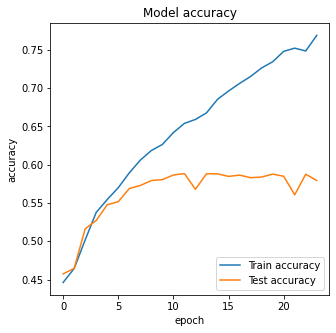

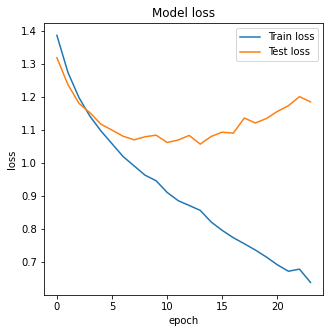

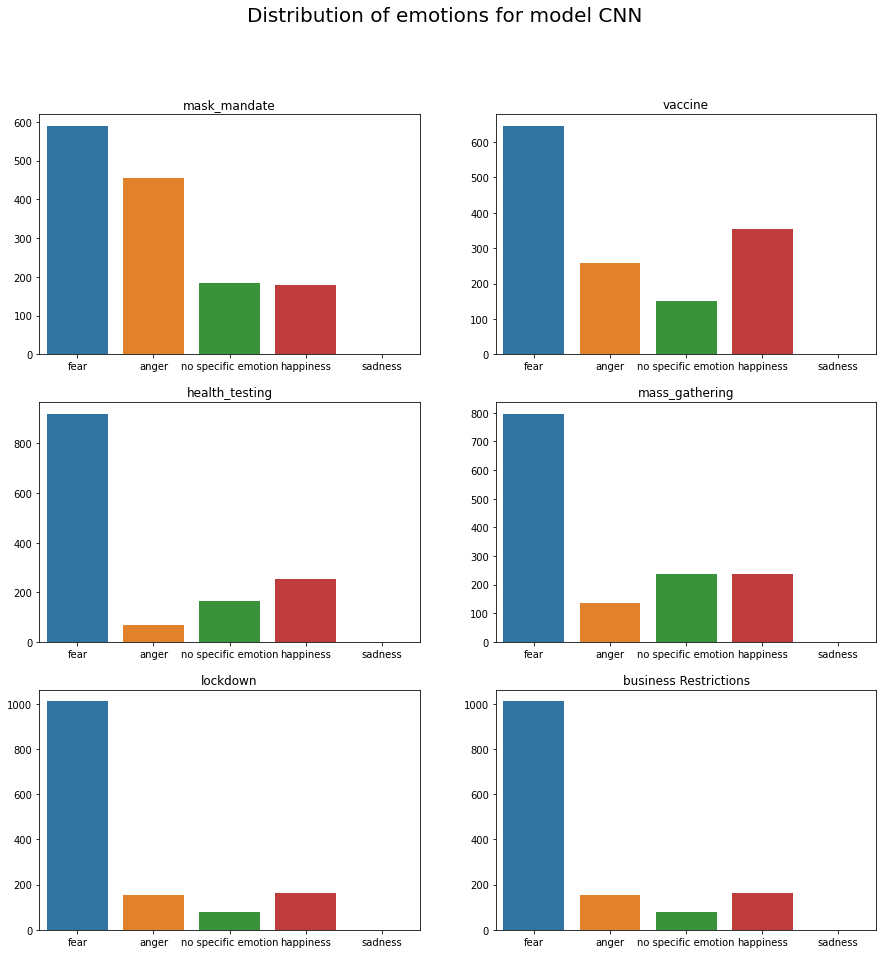

In [ ]:
plot_history(cnn_model_history)
plot_all_graphs(cnn_model, df, "CNN")

# LSTM

In [ ]:
lstm_model = Sequential([
        embedding_layer,
        tf.keras.layers.LSTM(256, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(64),
        # tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='sigmoid'),
    ])
lstm_model.summary()
lstm_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size = 1000,  callbacks=cb, epochs=50, validation_data=(X_test, y_test), verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 100)          1261700   
                                                                 
 lstm (LSTM)                 (None, 280, 256)          365568    
                                                                 
 dropout (Dropout)           (None, 280, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                82176     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 1,713,929
Trainable params: 452,229
Non-

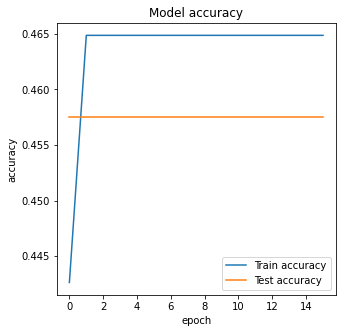

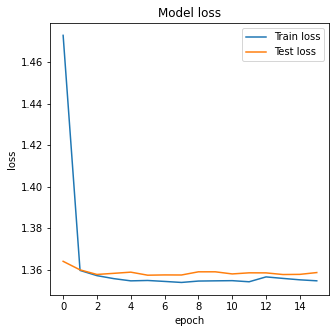

In [ ]:
plot_history(lstm_model_history)

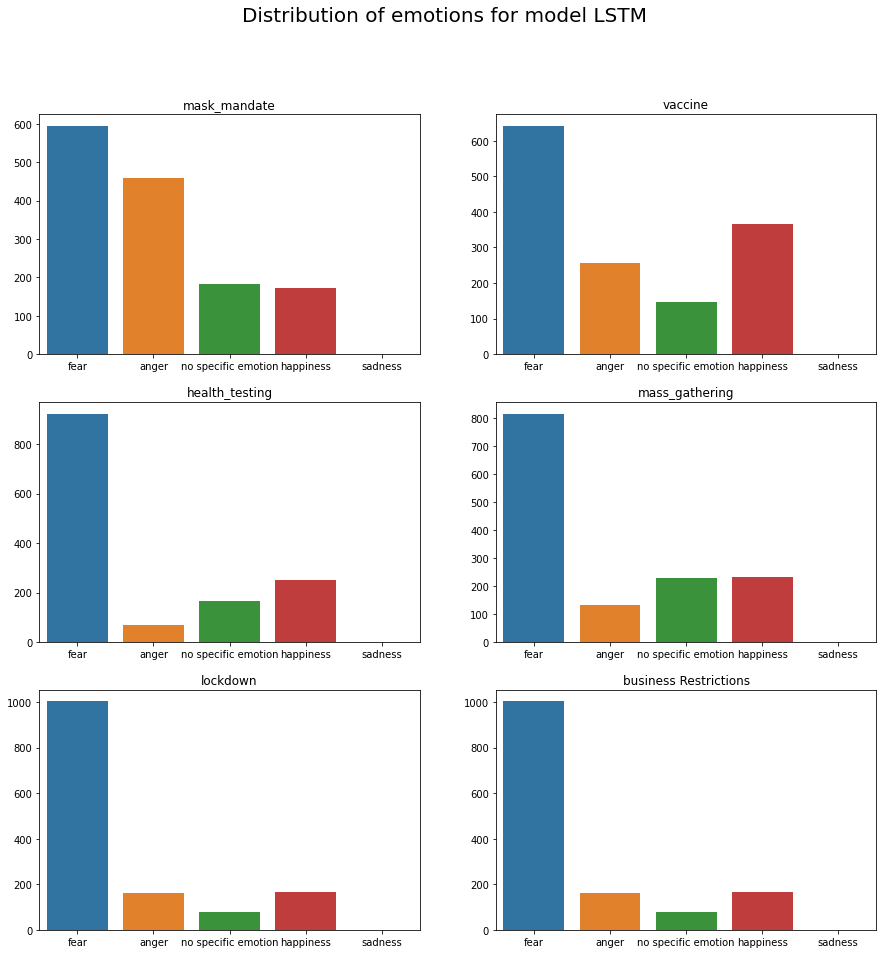

In [ ]:
# plot_all_graphs(cnn_model, df, "LSTM")
plot_all_graph(lstm_model, "LSTM")

# Bidirectional LSTM

In [ ]:
# Bidirectional LSTM
bidirectional_model = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(64)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='sigmoid'),
    ])

bidirectional_model.summary()
bidirectional_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
bidirectional_model_history = bidirectional_model.fit(X_train, y_train, batch_size = 1000,  callbacks=cb, epochs=50, validation_data=(X_test, y_test), verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 100)          1261700   
                                                                 
 bidirectional (Bidirectiona  (None, 280, 128)         84480     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 280, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

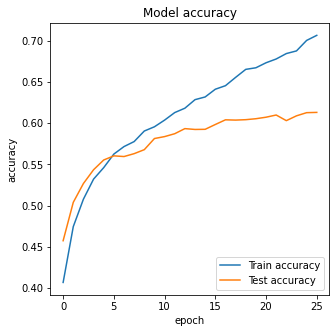

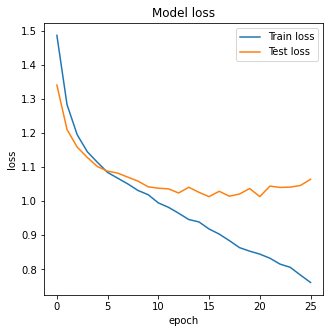

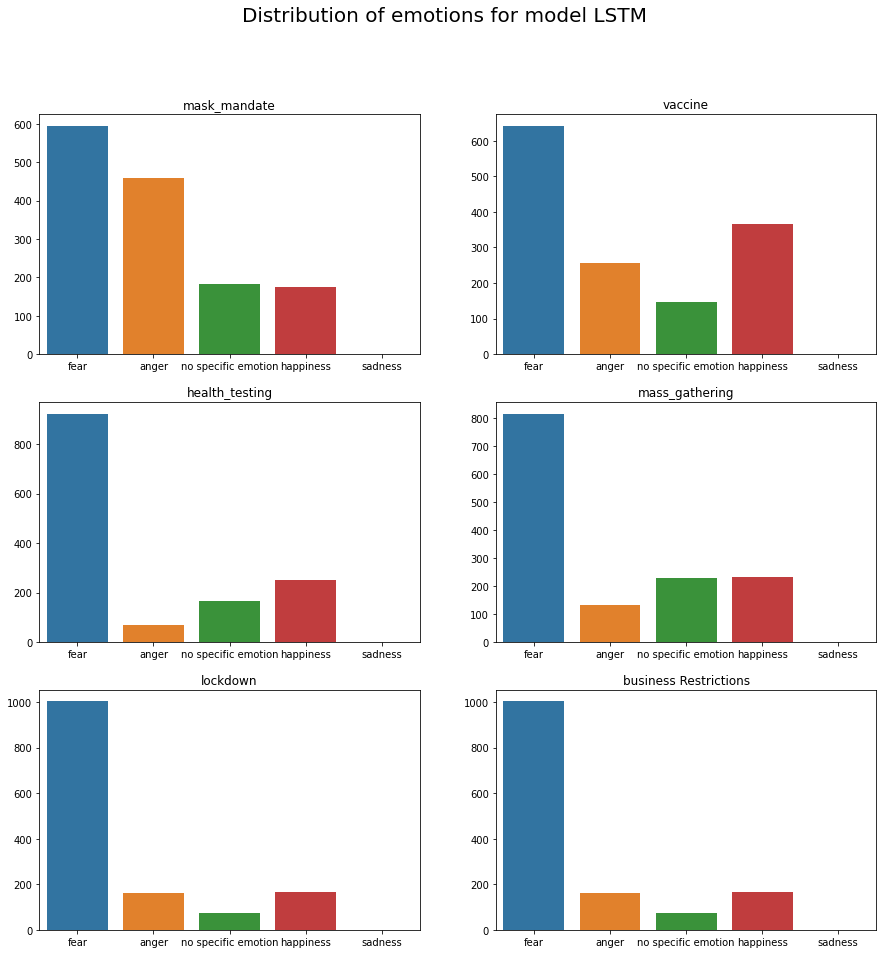

In [ ]:
plot_history(bidirectional_model_history)
# 
plot_all_graphs(bidirectional_model, df, "BiLSTM")

# CNN with Bidirectional LSTM

In [ ]:
lstm_cnn_model = Sequential([
        embedding_layer,
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(64)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='sigmoid')
    ])

lstm_cnn_model.summary()
lstm_cnn_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
lstm_cnn_model_history = lstm_cnn_model.fit(X_train, y_train, batch_size = 1000,  callbacks=cb, epochs=50, validation_data=(X_test, y_test), verbose=2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 100)          1261700   
                                                                 
 conv1d_17 (Conv1D)          (None, 280, 32)           9632      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 140, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 140, 64)           6208      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 70, 64)           0         
 g1D)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 70, 128)         

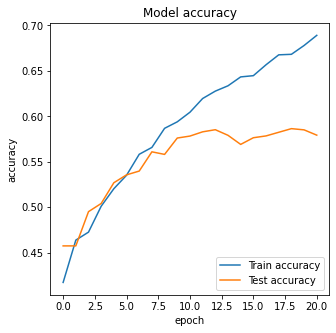

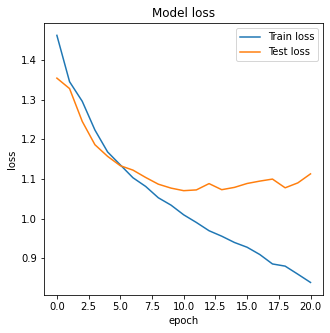

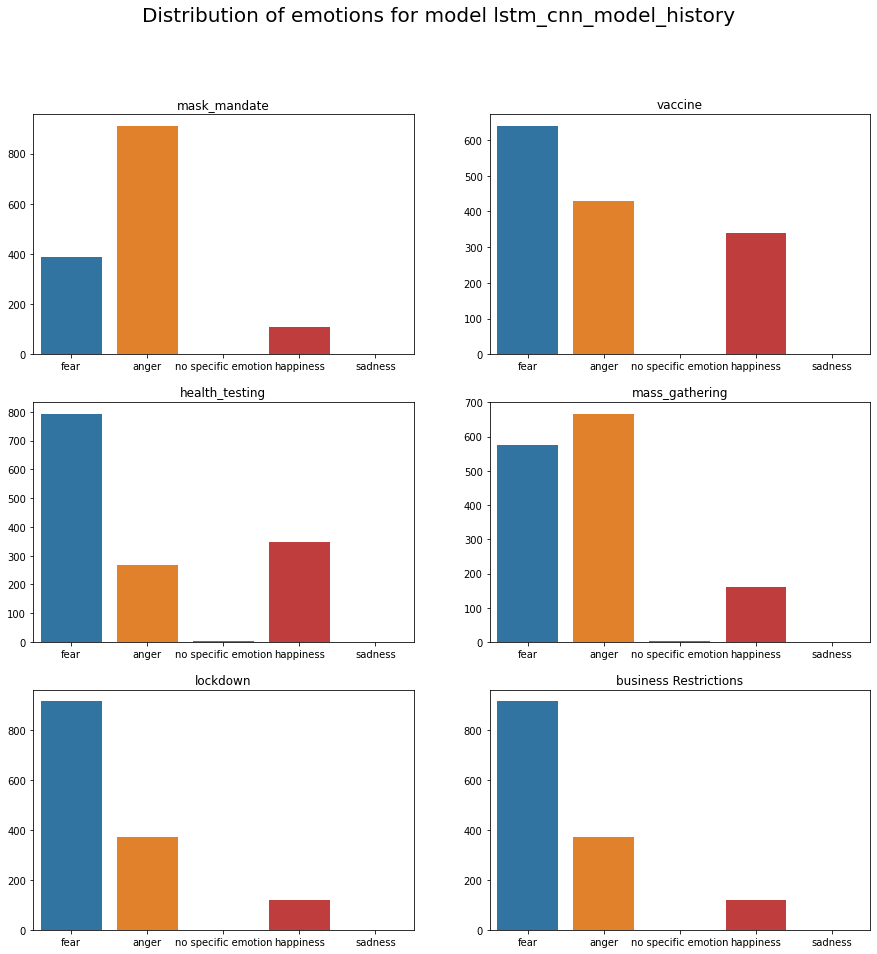

In [ ]:
plot_history(lstm_cnn_model_history)
plot_all_graphs(lstm_cnn_model, df, "lstm_cnn_model_history")